## Implementación del Paper: "Up-Sampling Method for Low-Resolution LiDAR Point Cloud to Enhance 3D Object Detection in an Autonomous Driving Environment"

In [1]:
import os
import sys
#sys.path.append(r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\LIDAR_super_resolution\Scripts\main\main_16to64\utils')
from pointcloud_utils_functions_v2 import *
from config import *

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_windows(x, upscaling_factor=2):
    #padding:(agregar n filas, agregar n columnas)
    #stride(de a cuantas filas me muevo:de a cuantas columnas me muevo)
    kernel_size = (2,3)#(upsampling_factor, upsampling_factor+1) #upsampling x2 --> kernel: 2x3 // upsampling x4 --> kernel:5x5
    padding = (0,1)
    stride = (1,1)
    #new_pixel_coords_batch = new_pixel_coords.unsqueeze(0).repeat(x.shape[0],1,1).to(device)

    if upscaling_factor == 2:
        windows = F.unfold(x, kernel_size=kernel_size, padding=padding, stride=stride)
        windows = windows.transpose(1, 2) #Obtener los valores de la ventana o kernel ordenados por fila, donde cada fila representa una ventana serializada
        #windows = torch.dstack((windows, new_pixel_coords_batch))
    else:
        print("ERROR: Wrong Upsampling factor")
    return windows

a = torch.tensor([[[[1.,2.,3.,4.], [1.,2.,3.,4.], [1.,2.,3.,4.], [1.,2.,3.,4.], [1.,2.,3.,4.]]], [[[1.,2.,3.,4.], [1.,2.,3.,4.], [1.,2.,3.,4.], [1.,2.,3.,4.], [1.,2.,3.,4.]]]])
windows = get_windows(a)
print(windows.shape)
windows_stack = windows.reshape(windows.shape[0] * windows.shape[1], windows.shape[2])
print(windows_stack.shape)
res = torch.ones((32,1))
res = res.view(a.shape[0], a.shape[1], -1, a.shape[-1])
res.shape


torch.Size([2, 16, 6])
torch.Size([32, 6])


torch.Size([2, 1, 4, 4])

In [17]:
res = torch.ones((2,32,1))
print(res.squeeze().shape)

torch.Size([2, 32])


In [5]:
import os

# Ruta de la carpeta que contiene los archivos
carpeta = r'C:\Users\Nicolas\Desktop\training_64x2048'

# Itera sobre todos los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta):
    # Construye el path completo del archivo
    path_original = os.path.join(carpeta, nombre_archivo)

    # Si es un archivo (y no un directorio)
    if os.path.isfile(path_original):
        # Nuevo nombre del archivo (puedes personalizar esta lógica según tus necesidades)
        nuevo_nombre = nombre_archivo[6:]

        # Construye el path completo del nuevo nombre
        path_nuevo = os.path.join(carpeta, nuevo_nombre)

        # Renombra el archivo
        os.rename(path_original, path_nuevo)

print("Archivos renombrados correctamente.")

Archivos renombrados correctamente.


In [9]:
#Mix Distance and Intensity images
save_path = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\LIDAR_super_resolution\Complex-YOLO\dataset\kitti\training\velodyne_64_range_images_originales'
distance_images_folder = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\range_distance_images_3d_object\training_64x2048'
intensity_images_folder = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\range_intensity_images_3d_object\training_64x2048'
images_name = os.listdir(distance_images_folder)

for i, img_name in enumerate(images_name):
    distance_image = np.load(os.path.join(distance_images_folder,img_name))
    intensity_image = np.load(os.path.join(intensity_images_folder,img_name))
    pointcloud = range_image_to_pointcloud_with_instensity(distance_image, intensity_image)
    save_name = f'{str(i).zfill(6)}.bin'
    save_bin(pointcloud, os.path.join(save_path, save_name))

In [3]:
path = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\kitti_3d_object\testing\velodyne\000001.bin'
#path = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\kitti_3d_object\training\velodyne\000054.bin'
pointcloud = read_bin(path)
hr_range_distance_image = pointcloud_to_range_image(pointcloud, filter_ego_compensed=True, kind='distance', size=(64,1024))

downsampling_factor = 4
ind = np.arange(0,64,downsampling_factor)
lr_range_distance_image = hr_range_distance_image[ind] / kitti_max_distance
#display_range_image(lr_range_distance_image)
#display_range_image(hr_range_distance_image)

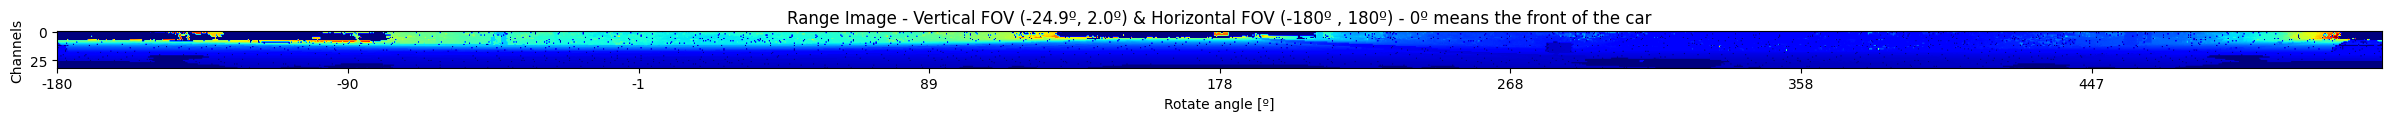

Size: (32, 2048)


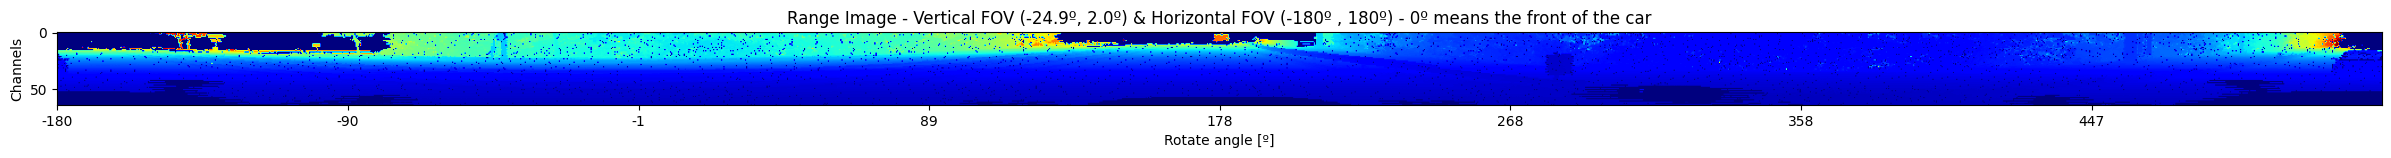

Size: (64, 2048)


In [2]:
path = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\range_distance_images_3d_object\training_64x2048\drive_000001.npy'
#path = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\kitti_3d_object\training\velodyne\000054.bin'
hr_range_distance_image = np.load(path)

downsampling_factor = 2
ind = np.arange(0,64,downsampling_factor)
lr_range_distance_image = hr_range_distance_image[ind] / kitti_max_distance
display_range_image(lr_range_distance_image)
display_range_image(hr_range_distance_image)

In [3]:
def calculate_weight(window, upsampling_factor, border):

    def weight_function(distances, kernel):
        nonzero_pos = [kernel != 0][0].astype(int)
        y = np.exp(-0.5*distances) * (2 / (1 + np.exp(kernel - np.amin(kernel)))) * nonzero_pos #Solo considero los valores que cumplen la condición de que sean mayores que 0
        return y
    
    def pixel_value_function(kernel, target):
        pixels_indices = np.where(kernel >= 0) #No consideros los pixeles iguales a -1 que pongo cuando creo la imagen resultado
        distances = np.sqrt((pixels_indices[0] - target[0]) ** 2 + (pixels_indices[1] - target[1]) ** 2) #Distancias a los 6 píxeles disitntos a -1 de la ventana
        pixel_value_num = np.sum(weight_function(distances, kernel[pixels_indices]) * kernel[pixels_indices])
        pixel_value_den = np.sum(weight_function(distances, kernel[pixels_indices]))
        if pixel_value_den == 0:
            pixel_value_den = 1
        return pixel_value_num / pixel_value_den

    if upsampling_factor == 2:
        if border == 'left':
            pixel = pixel_value_function(window, (1,0)) #target:(fila de la ventana, columna de la ventana)   
        elif border == 'right':
            pixel = pixel_value_function(window, (1,2))
        elif border == 'center':
            pixel = pixel_value_function(window, (1,1))
        else:
            print("ERROR: Wrong kernel position")
    elif upsampling_factor == 4:
        if border == 'left':
            pixel = [pixel_value_function(window, (1,0)), pixel_value_function(window, (2,0)), pixel_value_function(window, (3,0))] #target:(fila de la ventana, columna de la ventana)   
        elif border == 'right':
            pixel = [pixel_value_function(window, (1,2)), pixel_value_function(window, (2,2)), pixel_value_function(window, (3,2))] #target:(fila de la ventana, columna de la ventana)   
        elif border == 'center':
            pixel = [pixel_value_function(window, (1,1)), pixel_value_function(window, (2,1)), pixel_value_function(window, (3,1))] #target:(fila de la ventana, columna de la ventana)   
        else:
            print("ERROR: Wrong kernel position")    
    else:
        print("Wrong interpolation factor, only can interpolate x2 and x4")
    return pixel

def weigthed_conv(image, upsampling_factor):
    #Intercalamos filas de -1s entre cada fila de la imagen
    result = np.full((image.shape[0]*upsampling_factor, image.shape[1]), -1, dtype=np.float32)
    for i in range(0, image.shape[0]*upsampling_factor, upsampling_factor):
        result[i,:] = image[i//upsampling_factor,:]
    
    if upsampling_factor == 2:
        result[-1,:] = image[-1,:] #Copio la última fila para simplificar los cálculos, luego podría mejorarse la implementación
    elif upsampling_factor == 4:
        result[-3:,:] = image[-1:,:] #Copio la última fila para simplificar los cálculos, luego podría mejorarse la implementación
    #print(result)
    #display_range_image(result)
    
    if upsampling_factor == 2:
        #Recorro la imagen de izquierda a derecha y luego bajo 3 o 5 filas dependiendo la interpolación (x2 o x4 respectivamente)
        for row_id in range(0, result.shape[0]-3, upsampling_factor):
            for column_id in range (result.shape[1]): #las columnas siempre son de a 3, lo que varía con el downsampling es el row_id
                if column_id == 0 and (row_id % 2) == 0:
                    result[row_id+1,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id:column_id+3], upsampling_factor, border='left')
                elif column_id == result.shape[1]-1:
                    result[row_id+1,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id-2:column_id+1], upsampling_factor, border='right')
                else:
                    result[row_id+1,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id-1:column_id+2], upsampling_factor, border='center')
        #display_range_image(result)
        #print(result)
    elif upsampling_factor == 4:
        #Recorro la imagen de izquierda a derecha y luego bajo 3 o 5 filas dependiendo la interpolación (x2 o x4 respectivamente)
        for row_id in range(0, result.shape[0]-5, upsampling_factor):
            for column_id in range (result.shape[1]): #las columnas siempre son de a 3, lo que varía con el downsampling es el row_id
                if column_id == 0 and (row_id % 4) == 0:
                    result[row_id+1:row_id+4,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id:column_id+3], upsampling_factor, border='left')
                elif column_id == result.shape[1]-1:
                    result[row_id+1:row_id+4,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id-2:column_id+1], upsampling_factor, border='right')
                else:
                    result[row_id+1:row_id+4,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id-1:column_id+2], upsampling_factor, border='center')
        #display_range_image(result)
        #print(result)
    return result

In [4]:
result_32 = weigthed_conv(lr_range_distance_image, upsampling_factor=2)
result_32 = result_32 * kitti_max_distance

In [21]:
print(hr_range_distance_image[:3,1500:1504])
print(result_32[:3,1500:1504])

[[9.65992  9.623738 9.63779  9.04951 ]
 [9.600954 9.040674 9.006619 9.040923]
 [9.146802 9.033064 8.942686 8.895579]]
[[9.65992  9.623738 9.63779  9.04951 ]
 [9.386173 9.34672  9.226038 9.11644 ]
 [9.146802 9.033064 8.942686 8.895579]]


In [8]:
#result_32 = weigthed_conv(lr_range_distance_image, upsampling_factor=2)
#result_64_x2 = weigthed_conv(result_32, upsampling_factor=2)
#result_64 = weigthed_conv(lr_range_distance_image, upsampling_factor=4)

#test = np.expand_dims(np.arange(8), axis=1)
#test = test * test.T
#a = weigthed_conv(test, upsampling_factor=4)
#print(test)
#print(a)

In [5]:
pointcloud_64_up = range_image_to_pointcloud(result_32)

In [6]:
np.save(r'./prueba.npy', pointcloud_64_up)

In [7]:
save_bin(pointcloud_64_up, r'./prueba.bin')

### Primera versión

In [3]:
def calculate_weight(window, upsampling_factor, border):

    def weight_function(x):
        return np.exp(-0.5*x)

    if upsampling_factor == 2:
        if border == 'left':
            window = np.delete(window,(1), axis = 0) #eliminamos la fila de 0 para que no influya en el calculo de la media
            window = window[:,:2]
            new_weights = window.mean(axis=0)[0]
        elif border == 'right':
            window = np.delete(window,(1), axis = 0) #eliminamos la fila de 0 para que no influya en el calculo de la media
            window = window[:,-2:]
            new_weights = window.mean(axis=0)[-1]
        elif border == 'center':
            window = np.delete(window,(1), axis = 0) #eliminamos la fila de 0 para que no influya en el calculo de la media
            new_weights = window.mean(axis=0)[1]
        else:
            print("ERROR: Wrong kernel position")
    elif upsampling_factor == 4:
        pass    
    else:
        print("Wrong interpolation factor, only can interpolate x2 and x4")
    return new_weights


def weigthed_conv(image, upsampling_factor):
    #Intercalamos filas de 0s entre cada fila de la imagen
    result = np.zeros((image.shape[0]*upsampling_factor, image.shape[1]))
    for i in range(0, image.shape[0]*upsampling_factor, upsampling_factor):
        result[i,:] = image[i//upsampling_factor,:]
    result[-1,:] = image[-1,:] #Copio la última fila para simplificar los cálculos, luego podría mejorarse la implementación
    #print(result)
    #display_range_image(result)
    
    if upsampling_factor == 2:
        #Recorro la imagen de izquierda a derecha y luego bajo 3 o 5 filas dependiendo la interpolación (x2 o x4 respectivamente)
        for row_id in range(0, result.shape[0]-3, upsampling_factor):
            for column_id in range (result.shape[1]): #las columnas siempre son de a 3, lo que varía con el downsampling es el row_id
                if column_id == 0 and (row_id % 2) == 0:
                    result[row_id+1,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id:column_id+3], upsampling_factor, border='left')
                elif column_id == result.shape[1]-1:
                    result[row_id+1,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id-2:column_id+1], upsampling_factor, border='right')
                else:
                    result[row_id+1,column_id] = calculate_weight(result[row_id:row_id+upsampling_factor+1, column_id-1:column_id+2], upsampling_factor, border='center')
        #display_range_image(result)
        #print(result)
    return result

result_32 = weigthed_conv(lr_range_distance_image, upsampling_factor=2)
result_64 = weigthed_conv(result_32, upsampling_factor=2)

#test = np.expand_dims(np.arange(8), axis=1)
#test = test * test.T
#a = weigthed_conv(test, upsampling_factor=2)
#a.shape

### Continuación

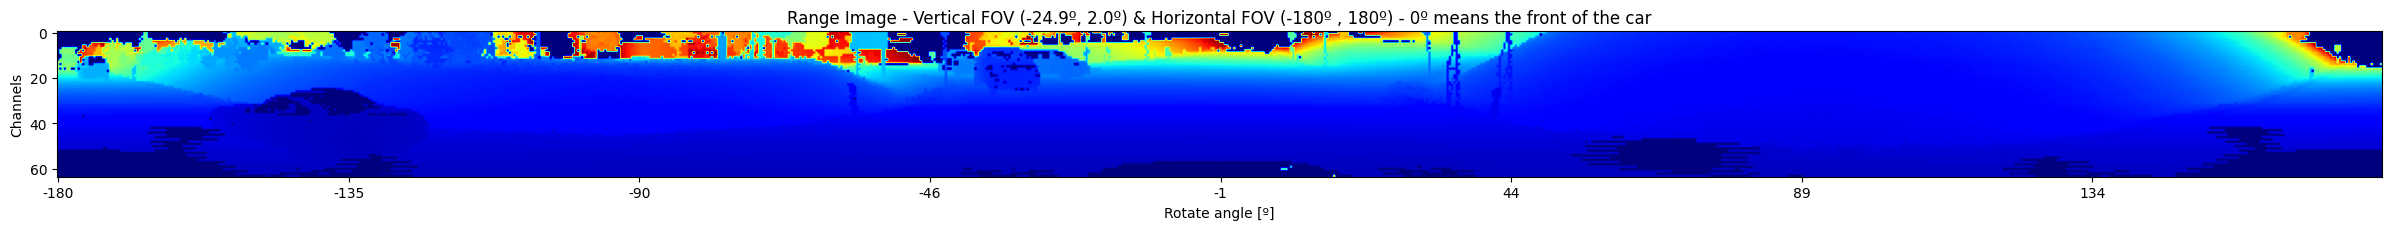

Size: (64, 1024)


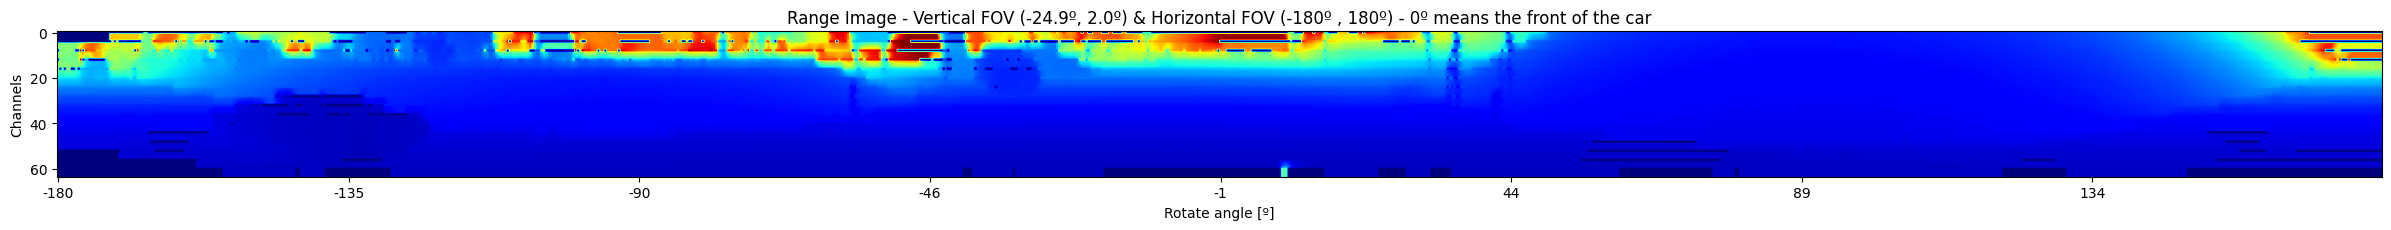

Size: (64, 1024)


In [5]:
display_range_image(hr_range_distance_image)
#display_range_image(result_32)
#display_range_image(result_64_x2)
display_range_image(result_64)

In [6]:
io.imsave(r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\LIDAR_super_resolution\Scripts\evaluacion_resultados\nubes_de_puntos\test_error_range_images\hr_original.tif', hr_range_distance_image)
io.imsave(r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\LIDAR_super_resolution\Scripts\evaluacion_resultados\nubes_de_puntos\test_error_range_images\paper.tif', result_64)

In [15]:
pointcloud = range_image_to_pointcloud(result_32 * kitti_max_distance)

save_PATH = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\LIDAR_super_resolution\Scripts\evaluacion_resultados\nubes_de_puntos\ego_motion_filtered\a.ply'
save_ply(pointcloud, save_PATH)